In [105]:
from datasets.pamap2 import PAMAP2
from datasets.opportunity import Opportunity
from datasets.mmfit import MMFit
from datasets.motionsense import MotionSense
from datasets.mhealth import MHEALTH
from datasets.wisdm import WISDM

from models.cnn import CNN
from models.convlstm import ConvLSTM
from models.gru import GRU
from models.lstm import LSTM
from models.transformer import Transformer

import numpy as np
import csv
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import ast
import sys
from sklearn.metrics import f1_score


In [106]:
# DATASET LOOP
dir = './outputs/H100/'
DATASET_LIST = ['PAMAP2','OPPORTUNITY','MMFIT','MHEALTH','MOTIONSENSE','WISDM']
MODEL_LIST = ['CNN','CONVLSTM','GRU','LSTM','TRANSFORMER','CPC']

BATCH_LIST = [64, 256, 1024]
LR_LIST = [0.1, 0.01, 0.001]

WINDOW = 200
STRIDE = 100

STEP = 20
GAMMA = 0.5
PATIENCE = 40
NUM_EPOCHS = 200
best_rows = {}

for DATASET in DATASET_LIST:   
    # MODEL LOOP
    for MODEL in MODEL_LIST:
        print("\nDATASET: " + DATASET)
        print("MODEL: " + MODEL)

        best_accuracy = 0
        best_loss = float('inf')
        best_batch = 0
        best_lr = 0
        best_exp_id = []
        
       
        for BATCH in BATCH_LIST:
            for LR in LR_LIST:
                total_accuracy = 0
                total_loss = 0
                total_rows = 0
                exp_id = []
                rows = []
                with open(dir + DATASET+'_'+MODEL+'.csv', 'r') as csvfile:
                    csvreader = csv.reader(csvfile)
                    for row in csvreader:
                        if int(row[3]) == BATCH and float(row[4]) == LR:
                            #print(row)
                            
                            total_accuracy += float(row[8])
                            total_loss += float(row[9]) 
                            total_rows += 1
                            exp_id.append(row[0])
                            rows.append(row)
                
                # rows = sorted(rows, key=lambda x: x[5])
                # print(rows)
                average_accuracy = total_accuracy / total_rows if total_rows > 0 else 0
                #print(average_accuracy)
                average_loss = total_loss / total_rows if total_rows > 0 else float('inf')

                if average_accuracy > best_accuracy:
                    best_accuracy = average_accuracy
                    best_loss = average_loss
                    best_batch = BATCH
                    best_lr = LR
                    best_exp_id=exp_id
                    best_rows[(DATASET, MODEL)] = rows


        # Output the best batch size and learning rate
        print("Best Batch Size:", best_batch)
        print("Best Learning Rate:", best_lr)
        print("Best Accuracy:", best_accuracy)
        print("Best Loss:", best_loss)
        print("Best IDs:", best_exp_id)


# pprint(best_rows)
print(best_rows)
                   
                
            


DATASET: PAMAP2
MODEL: CNN
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.6583331289905543
Best Loss: 1.2790684447478147
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: CONVLSTM
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.708407681609401
Best Loss: 0.9856696200815881
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: GRU
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.6594467031269567
Best Loss: 1.314249312944287
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: LSTM
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.6594911273312486
Best Loss: 1.2575467278700228
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: TRANSFORMER
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.7485665669164424
Best Loss: 0.8517638966828149
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47'

In [107]:
WINDOW = 200
STRIDE = 100

# ds = PAMAP2(users=[2], window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=[1, 2, 3, 4, 5, 6, 7, 8])
# print(len(ds))
# x_data= [ds[i][0][0][[1,2,3]] for i in range(0,len(ds))]
# x_data = [tensor.numpy() for tensor in x_data]
# x_data = np.vstack(x_data)
# print(x_data.shape)

In [108]:
import numpy as np

def is_outperforming_first(margins):
    # Extract the margin of the first entry
    first_margin = margins[0]
    
    # Check if the margin of the first entry is greater than all the other margins
    is_outperforming = all(first_margin > margin for margin in margins[1:])
    
    return is_outperforming

# Example array of margins
margins = np.array([0.5, 0.6, 0.4, 0.2])

# Check if the first entry is outperforming the others
result = is_outperforming_first(margins)

if result:
    print("The first entry is outperforming the others.")
else:
    print("The first entry is not outperforming the others.")

The first entry is not outperforming the others.


In [109]:
import matplotlib.pyplot as plt

vectors, gt, predict, sensors = [], [], [], []

for dataset_id,DATASET in enumerate(DATASET_LIST):
    dataset_vectors, dataset_predict=  [],[]
    
    sensorLoader = 0
    for MODEL in MODEL_LIST:
        model_vectors, model_gt, model_predict, model_sensors = [], [], [], []
        
        for person in best_rows[DATASET, MODEL]:
            data = np.load(dir + DATASET + '_' + MODEL + '_' + person[0] + '.npz', allow_pickle=True)
            y = np.concatenate(data['y'])
            y= y.astype(int)
            outputs = np.concatenate(data['outputs'])
            max_outputs = np.argmax(outputs, axis=1)

            comparison = y != max_outputs
            result = comparison.astype(int)

            model_vectors.append(result)
            model_predict.append(outputs)
            # print(person[5])
            if sensorLoader==0:
                print(y[0])
                model_gt.append(y)

                
                if DATASET == 'PAMAP2':
                    print("PAMAP2")
                    indices = [0, 1, 2, 13, 14, 15, 26, 27, 28]
                    ds = PAMAP2(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=[1, 2, 3, 4, 5, 6, 7, 8])
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET=='OPPORTUNITY':
                    print("OPPORTUNITY")
                    indices = [i for i in range(1, 17)]
                    ds = Opportunity(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE)
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MMFIT':
                    print("MMFIT")
                    indices = [0,1,2,6,7,8,12,13,14,18,19,20]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    usr_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
                    ds = MMFit(users=[usr_list[i] for i in ast.literal_eval(person[5])], window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MHEALTH':
                    print("MHEALTH")
                    indices = [0,1,2,3,4,5,12,13,14]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    ds = MHEALTH(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE, train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MOTIONSENSE':
                    print("MOTIONSENSE")
                    indices = [i for i in range(0, 12)]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    ds = MotionSense(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE, train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET=='WISDM':
                    print("WISDM")
                    indices = [i for i in range(0, 3)]
                    ds = WISDM(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE,train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36])
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                else:
                    print("Wrong DATASET")
                    sys.exit(0)

        
        dataset_vectors.append(model_vectors)
        dataset_predict.append(model_predict)
        # dataset_gt.append(model_gt)
        if sensorLoader==0:
            sensors.append(model_sensors)
            gt.append(model_gt)
            sensorLoader = 1
    
    print("F1 Scores")
    for pred in dataset_predict:
        concatenated_true = [item for sublist in gt[dataset_id] for item in sublist]
        concatenated_pred = [item for sublist in pred for item in sublist]
        concatenated_true = np.array(concatenated_true)
        concatenated_pred = np.array(concatenated_pred)
        print(f1_score(concatenated_true, np.argmax(concatenated_pred, axis=1), average='weighted'))
    
    vectors.append(dataset_vectors)
    predict.append(dataset_predict)

data = []
for dataset_id,DATASET in enumerate(DATASET_LIST):
    data.append([])
    for person_id, person in enumerate(best_rows[DATASET, 'CNN']):
        data[dataset_id].append([])

        result_sum = np.sum((vectors[dataset_id][i][person_id] for i in range(0,len(vectors[dataset_id]))),dtype=int)
        max_val = np.max(result_sum)  
        vec = np.zeros_like(result_sum)
        vec[result_sum == max_val] = 1 
        temp = []
        for model in range(0,len(MODEL_LIST)):
            temp.append(predict[dataset_id][model][person_id])
        
        temp = np.array(temp)
        y_mean = np.mean(temp, axis=0)
        # print(y_mean.shape)
        y_classes = np.argmax(y_mean, axis=1)
        y = np.where(vec == 1, y_classes, gt[dataset_id][person_id])
        data[dataset_id][person_id] = {'x':sensors[dataset_id][person_id],'y':y,'gt':gt[dataset_id][person_id],'pid':person[5],'vec':vec}



    
    
# pprint(data)

0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [3674, 468, 446, 512, 650, 185, 502, 594, 347, 304, 413, 578, 266]]
0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2915, 484, 458, 503, 631, 331, 509, 578, 234, 193, 486, 660, 177]]
0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2525, 544, 469, 435, 445, 426, 472, 405, 318, 299, 459, 471, 259]]
0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2048, 474, 537, 443, 641, 493, 491, 525, 285, 254, 489, 661, 153]]
0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2233, 467, 461, 487, 514, 457, 410, 534, 266, 225, 422, 755, 4]]
0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11], [1961, 461, 510, 494, 639, 454, 551, 334, 285, 401, 500]]
0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1616, 512, 246, 515, 674, 72, 454, 575, 353, 232, 431, 590]]
0
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 8, 9, 10, 11]

/var/folders/wd/jp3qk8gd7j9gb75gs1y7z_2c0000gp/T/ipykernel_10052/2271357471.py:100: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  result_sum = np.sum((vectors[dataset_id][i][person_id] for i in range(0,len(vectors[dataset_id]))),dtype=int)


In [110]:
for dataset_id,DATASET in enumerate(DATASET_LIST):
    length = 0
    for person_id, person in enumerate(best_rows[DATASET, 'CNN']):

        length+= len(data[dataset_id][person_id]['vec'])
    
    #print(length)
ds = PAMAP2(users='full', window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=[1, 2, 3, 4, 5, 6, 7, 8])
x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][:WINDOW//2][:] for i in range(len(ds))]])
print(len(x_data))
print(len(ds))

Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [18538, 3851, 3703, 3799, 4775, 1964, 3292, 3762, 2345, 2098, 3508, 4775, 859]]
5726900
57269


In [111]:
# def entropy(probabilities):
#     softmax_probs = np.exp(probabilities) / np.sum(np.exp(probabilities), axis=1, keepdims=True)
    
#     return softmax_probs


# for dataset_id,DATASET in enumerate(DATASET_LIST):
#     y_mean_dataset = np.empty((0, len(predict[dataset_id][0][0][0])))  
#     gt_dataset = np.empty((0)) 
#     for person_id, person in enumerate(best_rows[DATASET, 'CNN']):

#         temp = []
#         for model in range(0,len(MODEL_LIST)):
#             temp.append(predict[dataset_id][model][person_id])
#         temp = np.array(temp)

#         y_mean_dataset = np.append(y_mean_dataset, np.mean(temp, axis=0), axis=0)
#         gt_dataset = np.append(gt_dataset, gt[dataset_id][person_id], axis=0)
    
#     print(y_mean_dataset.shape)
#     print(gt_dataset.shape)
#     for i in range(0, len(predict[dataset_id][0][0][0])):
#         mask = (gt_dataset == i)[:, np.newaxis] 
#         class_probs = np.where(mask, y_mean_dataset, 0) 
#         entropy_value = entropy(class_probs)
#         print("Entropy for class", i, "in dataset", dataset_id, ":", np.mean(entropy_value))
#     print()
    
        
        

In [112]:
# OVERLAP MODEL ACCURACY OF ALL MODELS

for dataset_id, dataset in enumerate(data):
    zeros = 0
    ones = 0
    for person in dataset:
        vec = person['vec']
        zeros += np.count_nonzero(vec == 0)
        ones += np.count_nonzero(vec == 1)
    
    print(zeros/(zeros+ones))
    
    

0.882641568737013
0.9468626996990044
0.9956162085922312
0.9542160737812911
0.9954205027906311
0.9838931088130319


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
DATASET = 0
PARTICIPANT = 2



for dataset,_ in enumerate(DATASET_LIST):
    fig, axs = plt.subplots( len(data[dataset]),1, figsize=(25, 3*len(data[dataset])))
    for participant_idx in range(len(data[dataset])):
        ax = axs[ participant_idx]

        vis_data = data[dataset][participant_idx]

        segment_starts = []
        segment_ends = []

        vectors = vis_data["vec"]

        current_start = 0
        values = []
        values.append(vectors[0])
        for i in range(1, len(vectors)):
            if vectors[i] != vectors[i - 1]:
                segment_starts.append(current_start)
                segment_ends.append(i + 1)
                current_start = i + 1
                values.append(vectors[i])

        segment_starts.append(current_start)
        segment_ends.append(len(vectors) - 1)

        colors = ['white' if x == 0 else 'red' for x in values]
        for start, end, color in zip(segment_starts, segment_ends, colors):
            ax.axvspan(start, end, facecolor=color, alpha=0.3)

        gt = vis_data['gt']
        previous = 0
        for i in range(len(gt) - 1):
            if gt[i] != gt[i + 1] or i == len(gt) - 2:
               
                if dataset ==1 or dataset ==2:
                    ax.axvline(x=i, color='black', linestyle='--', linewidth=0.1)
                    ax.text(i - (i - previous) / 2, 3, f"{gt[i]}", va='bottom', ha='center', color='black', fontsize=12)
                else:
                    ax.axvline(x=i, color='black', linestyle='--', linewidth=0.5)
                    ax.text(i - (i - previous) / 2, 6, f"{gt[i]}", va='bottom', ha='center', color='black', fontsize=12)
                previous = i

        x = vis_data['x']

        ax.plot(range(0, len(x)), x[:, :], linewidth=1)
        if dataset ==1:
            ax.set_ylim(-1, 1)
        else:
            ax.set_ylim(-6, 7)
        ax.set_xlim(0, len(x))

        lpo = str(vis_data['pid'].strip("[]"))
        ax.set_title(str(DATASET_LIST[dataset]) + '  LPO ' + lpo)

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.2, wspace=0)
  
    plt.savefig(f'images/window_view_{DATASET_LIST[dataset]}.png',bbox_inches='tight')
    plt.show()

2235


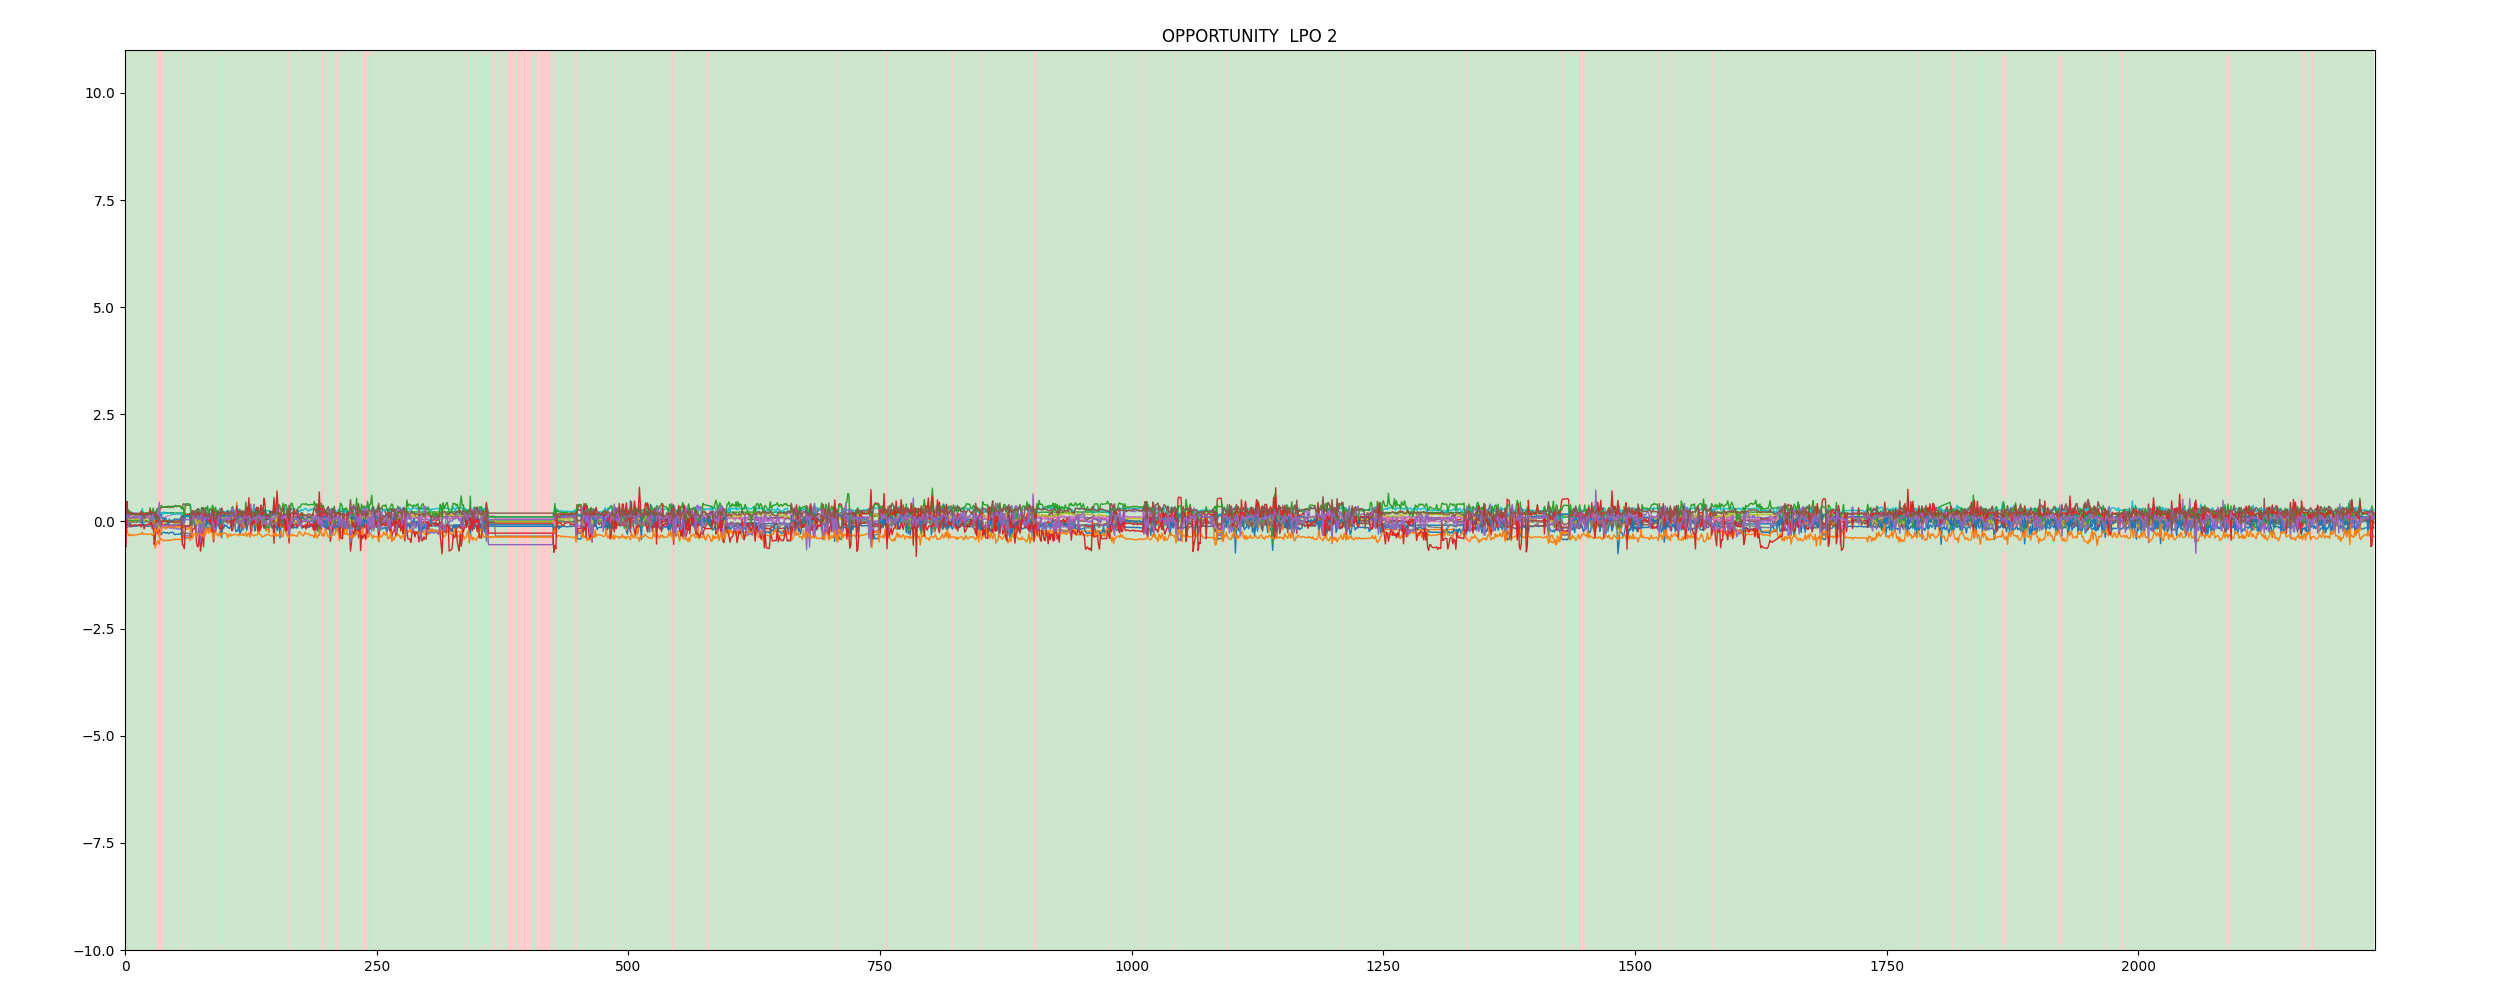

In [123]:
%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
DATASET = 1
PARTICIPANT = 1

vis_data = data[DATASET][PARTICIPANT]
# print(len(sensors))
# result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)

# plt.bar(range(0,len(result_sum)),result_sum, width=1)

# plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


plt.figure(figsize=(25, 10))
# max_val = np.max(result_sum)  
# all_models = np.zeros_like(result_sum)
# all_models[result_sum == max_val] = 1  

segment_starts = []
segment_ends = []

vectors = vis_data["vec"]

current_start = 0
values = []
values.append(vectors[0])
for i in range(1, len(vectors)):
    if vectors[i] != vectors[i -1]:
        segment_starts.append(current_start)
        segment_ends.append(i+1)
        current_start = i+1
        values.append(vectors[i])

segment_starts.append(current_start)
segment_ends.append(len(vectors) -1)

colors = ['green' if x == 0 else 'red' for x in values]
for start, end, color in zip(segment_starts, segment_ends, colors):
    # plt.plot(range(start, end+1), np.full(end-start+1, 9), c=color, linewidth=20)
    plt.axvspan(start, end, facecolor=color, alpha=0.2)
    # if 'complete' not in model_labels_added:
    #     plt.text(start, 9, f"complete", va='center', ha='right', color='black', fontsize=10)
    #     model_labels_added.add('complete')

gt = vis_data['gt']
previous = 0
for i in range(len(gt) - 1):
    if gt[i] != gt[i + 1] or i ==len(gt)-2:
        plt.axvline(x=i, color='black', linestyle='--', linewidth=0.5)
        plt.text(i-(i-previous)/2, 10, f"{gt[i]}", va='bottom', ha='center', color='black', fontsize=12)
        previous = i

y = vis_data['y']
# pprint(y[0:100])
# pprint(vectors[0:100])
# pprint(gt[0:100])
previous = 0
for i in range(len(y) - 1):
    if y[i] != y[i + 1]:
        #plt.vlines(x=i,ymin=10.25,ymax=10.75, color='black', linestyle='--', linewidth=0.5)
        #plt.text(i-(i-previous)/2, 10.5, f"({y[i]})", va='bottom', ha='center', color='black', fontsize=8)
        previous = i

x = vis_data['x']
print(len(x))

#PAMAP2
#indices = [0, 1, 2, 13, 14, 15, 26, 27, 28]# acc
#indices = [3, 4, 5, 16, 17, 18, 29, 30, 31]# gyr
#indices = [6, 7, 8, 19, 20, 21, 32, 33, 34]# mag
plt.plot(range(0, len(x)), x[:,:], linewidth=1)

plt.ylim(-10,11)
plt.xlim(0,len(x))
plt.title(str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.savefig(f'images/window_view_{DATASET_LIST[DATASET]}_example.png',bbox_inches='tight')
plt.show()

6590


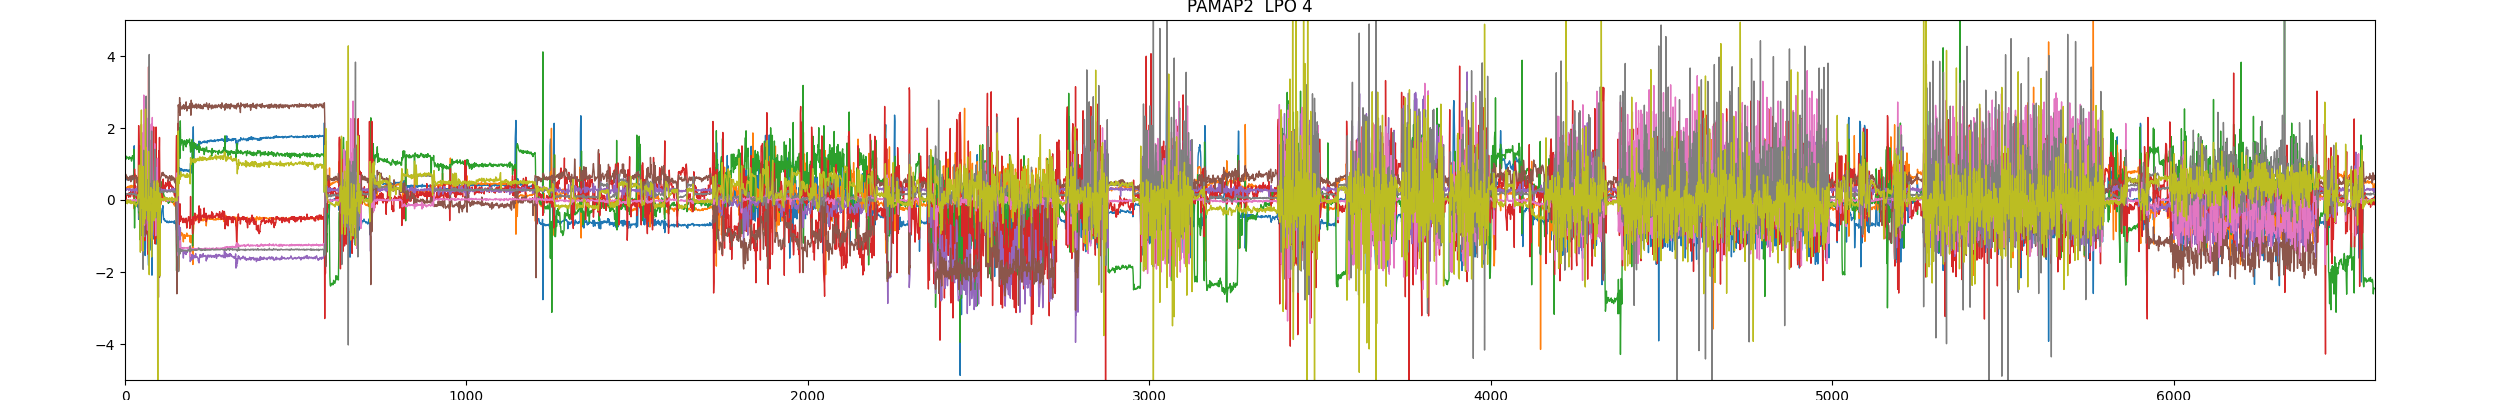

In [127]:
%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
DATASET = 0
PARTICIPANT = 5

vis_data = data[DATASET][PARTICIPANT]
# print(len(sensors))
# result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)

# plt.bar(range(0,len(result_sum)),result_sum, width=1)

# plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


plt.figure(figsize=(25, 4))
# max_val = np.max(result_sum)  
# all_models = np.zeros_like(result_sum)
# all_models[result_sum == max_val] = 1  

segment_starts = []
segment_ends = []

vectors = vis_data["vec"]

current_start = 0
values = []
values.append(vectors[0])
for i in range(1, len(vectors)):
    if vectors[i] != vectors[i -1]:
        segment_starts.append(current_start)
        segment_ends.append(i+1)
        current_start = i+1
        values.append(vectors[i])

segment_starts.append(current_start)
segment_ends.append(len(vectors) -1)

colors = ['green' if x == 0 else 'red' for x in values]
#for start, end, color in zip(segment_starts, segment_ends, colors):
    # plt.plot(range(start, end+1), np.full(end-start+1, 9), c=color, linewidth=20)
    #plt.axvspan(start, end, facecolor=color, alpha=0.2)
    # if 'complete' not in model_labels_added:
    #     plt.text(start, 9, f"complete", va='center', ha='right', color='black', fontsize=10)
    #     model_labels_added.add('complete')

gt = vis_data['gt']
previous = 0
for i in range(len(gt) - 1):
    if gt[i] != gt[i + 1] or i ==len(gt)-2:
        #plt.axvline(x=i, color='black', linestyle='--', linewidth=0.5)
        ##plt.text(i-(i-previous)/2, 10, f"{gt[i]}", va='bottom', ha='center', color='black', fontsize=12)
        previous = i

y = vis_data['y']
# pprint(y[0:100])
# pprint(vectors[0:100])
# pprint(gt[0:100])
previous = 0
for i in range(len(y) - 1):
    if y[i] != y[i + 1]:
        #plt.vlines(x=i,ymin=10.25,ymax=10.75, color='black', linestyle='--', linewidth=0.5)
        #plt.text(i-(i-previous)/2, 10.5, f"({y[i]})", va='bottom', ha='center', color='black', fontsize=8)
        previous = i

x = vis_data['x']
print(len(x))

#PAMAP2
#indices = [0, 1, 2, 13, 14, 15, 26, 27, 28]# acc
#indices = [3, 4, 5, 16, 17, 18, 29, 30, 31]# gyr
#indices = [6, 7, 8, 19, 20, 21, 32, 33, 34]# mag
plt.plot(range(0, len(x)), x[:,:], linewidth=1)

plt.ylim(-5,5)
plt.xlim(0,len(x))
plt.title(str(DATASET_LIST[DATASET])+'  LPO '+str(vis_data['pid'].strip("[]")))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.savefig(f'images/window_view_{DATASET_LIST[DATASET]}_teaser.png',bbox_inches='tight')
plt.show()

5.246682279469165
[  1   2   4  10  22  48 102 217 464]


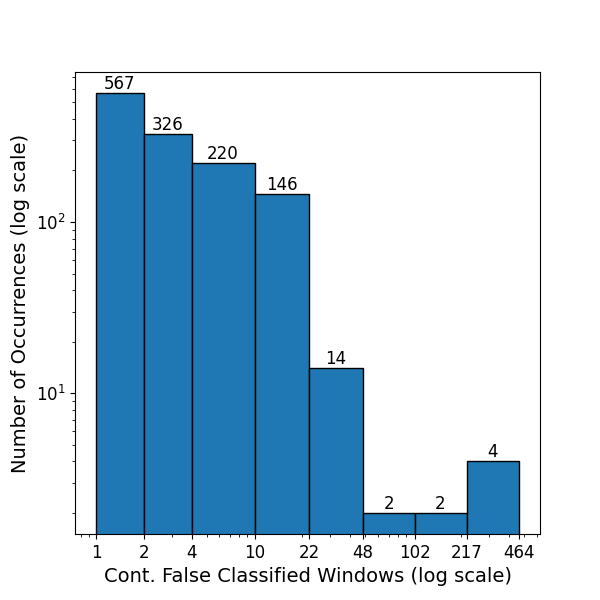

1.7452471482889733
[ 1  1  2  2  3  5  7 10 14]


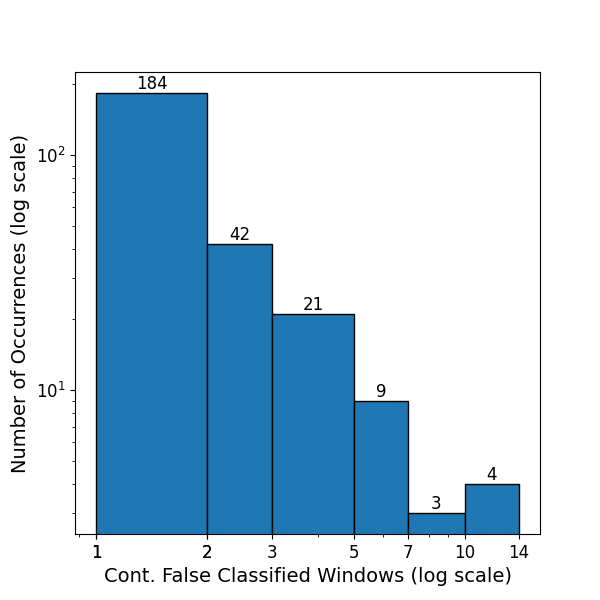

1.2637362637362637
[ 1  1  1  2  3  4  6  8 11]


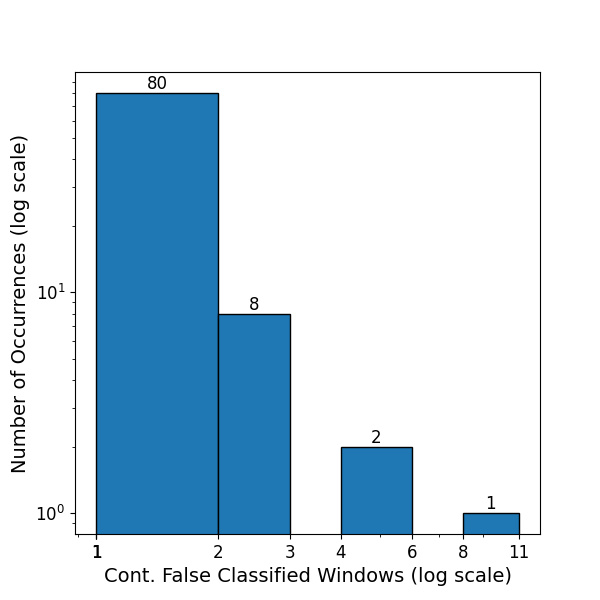

3.1412429378531073
[ 1  1  2  3  5  8 13 20 31]


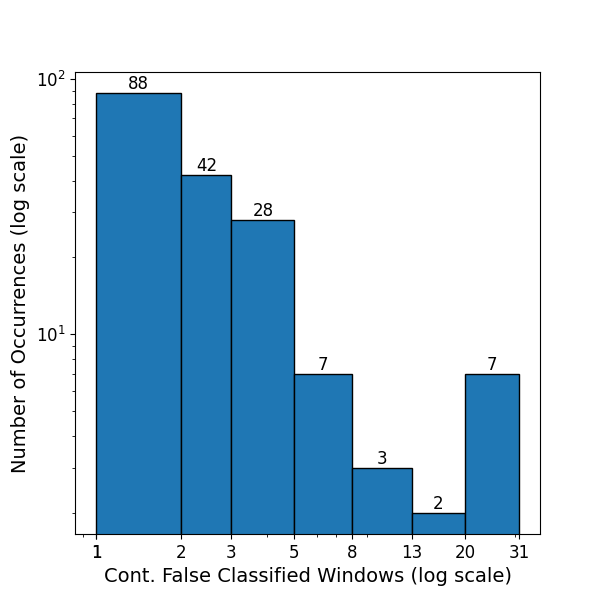

4.173913043478261
[ 1  1  2  3  5  8 12 18 28]


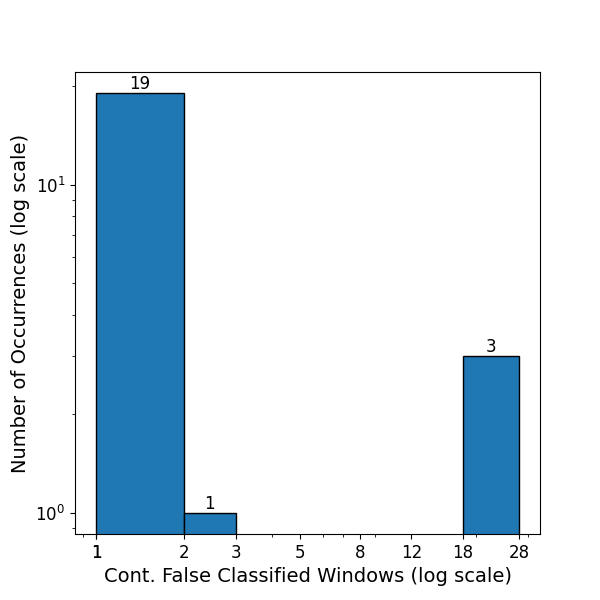

2.5142857142857142
[ 1  1  2  3  4  6 10 14 21]


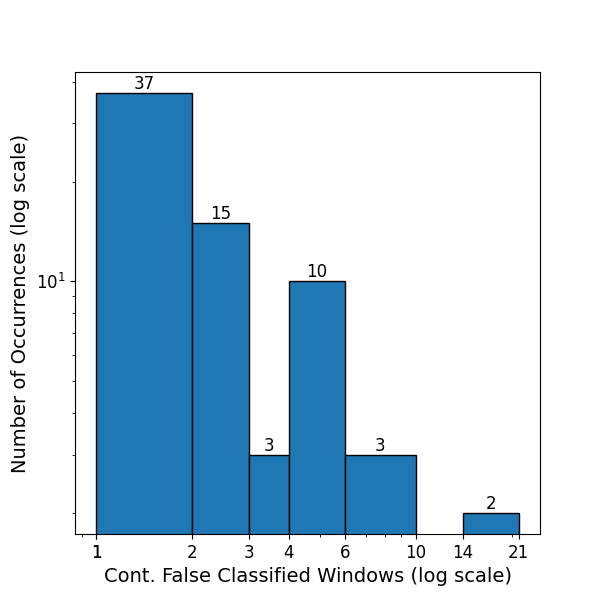

In [115]:
# HISTOGRAM OF WRONG CLASSES DURATION FOR EACH DATASET

THRESHOLD = 0
BINS = 8

for dataset_id, dataset in enumerate(data):
    plt.figure(figsize=(6, 6))
    durations = []
    for person in dataset:
        vec = person['vec']

        current_duration = 0
        for value in vec:
            if value == 1:
                current_duration += 1
            elif current_duration > 0:
                if current_duration > THRESHOLD:
                    durations.append(current_duration)
                current_duration = 0
        
        if current_duration > 0:
            durations.append(int(current_duration))

    print(np.mean(durations))
    max_duration = max(durations)
    min_duration = min(durations)
   
    # if max_duration % BINS != 0 and max_duration>BINS:
    #     max_duration = ((max_duration // BINS) + 1) * BINS
    bin_edges = np.geomspace(start=min_duration * 1.1, stop=max_duration, num=BINS+1, dtype=int)
    print(bin_edges)
    hist, bins, _ = plt.hist(durations, bins=bin_edges, edgecolor='black')
    plt.xlabel('Cont. False Classified Windows (log scale)', fontsize=14)  # Increase font size of x-label
    plt.ylabel('Number of Occurrences (log scale)', fontsize=14)  # Increase font size of y-label
    # plt.title(DATASET_LIST[dataset_id], fontsize=16) 
    plt.xscale('log')
    plt.yscale('log')
    

    for i in range(len(hist)):
        x_pos = np.sqrt(bins[i] * bins[i+1])  # Geometric mean of bin edges
        plt.text(x_pos, hist[i], str(int(hist[i])), ha='center', va='bottom',fontsize=12)
        
    
    plt.xticks(bin_edges, [str(label) for label in bin_edges], fontsize=12)
    plt.yticks(fontsize=12)
    # plt.tick_params(axis='both', which='both', length=4, width=0.5)
    plt.show()
    plt.savefig('images/histo_'+DATASET_LIST[dataset_id]+'.png')

In [116]:
# ['PAMAP2','OPPORTUNITY','MMFIT','MHEALTH','MOTIONSENSE','WISDM']

# labels = [
#     ['Null', 'Lying', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling', 'Nordicwalk', 'Upstairs', 'Downstairs', 'Vaccuum', 'Ironing', 'Ropejump'],
#     ['Others', 'Stand', 'Walk', 'Sit', 'Lie'],
#     ['Squats', 'Lunges', 'Bicep', 'Situps', 'Pushups', 'Tricep', 'Dumbbell_row', 'Jumping_jack', 'Dumbbell_shoulder', 'Shoulder', 'Null'],
#     ['Null', 'Standing', 'Sitting', 'Lying', 'Walking', 'Up_stairs', 'Waist_forward', 'Elevation_Arms', 'Crouching', 'Cycling', 'Jogging', 'Running', 'Jump'],
#     ['Sit', 'Stand', 'Walk', 'Upstairs', 'Downstairs', 'Jogging'],
#     ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
# ]

labels =[ [
            'Others',
            'Open_Door1',
            'Open_Door2',
            'Close_Door1',
            'Close_Door2',
            'Open_Fridge',
            'Close_Fridge',
            'Open_Dishwasher',
            'Close_Dishwasher',
            'Open_Drawer1',
            'Close_Drawer1',
            'Open_Drawer2',
            'Close_Drawer2',
            'Open_Drawer3',
            'Close_Drawer3',
            'Clean_Table',
            'Drink_Cup',
            'Toggle_Switch'
            ]]

In [117]:
# CONFUSED CLASSES

from collections import defaultdict
import pandas as pd


for dataset_id, dataset in enumerate(data):
    confusion_counts = defaultdict(lambda: defaultdict(int))

    total_full = 0
    for person in dataset:
        gt = person['gt']
        y = person['y']
        total_full+= len(gt)
        
        for true_class, pred_class in zip(gt, y):
            confusion_counts[true_class][pred_class] += 1

    df = pd.DataFrame(confusion_counts).fillna(0).astype(int)
    df = df.sort_index()
    df = df.reindex(sorted(df.columns), axis=1)

   
    print(total_full)

    print(f"Dataset: {DATASET_LIST[dataset_id]}")
    

    for true_class in df.index:
        confused_classes = df.loc[true_class][df.loc[true_class] > 0]
        total = sum(confused_classes)  
        # print(confused_classes)
        # print(total)
        true_class= int(true_class)
        print(f"True class: {labels[dataset_id][true_class]}: ", end="")
        if len(confused_classes) > 1:
            confused_classes_sorted = confused_classes.sort_values(ascending=False)
            
            for confused_class, count in confused_classes_sorted.items():
                confused_class = int(confused_class)
                if confused_class != true_class:
                    percentage = (count / total) * 100
                    print(f"{labels[dataset_id][confused_class]} ({percentage:.2f}% - {count}), ", end="")
            print()
            count_confused = sum(confused_classes_sorted.iloc[1:])
            print(f"Class Confusion in Class %: {count_confused/total*100}")
            # print(f"Class Confusion Absolute: {count_confused}")
            print(f"Class Confusion in Dataset %: {count_confused/total_full*100}")
            
        else:
            print("No confusion")
        
    print()


57269
Dataset: PAMAP2
True class: Others: Close_Door1 (6.35% - 1408), Open_Drawer2 (2.72% - 604), Open_Door2 (2.43% - 539), Open_Drawer1 (2.04% - 452), Close_Dishwasher (1.71% - 379), Close_Door2 (1.41% - 313), Close_Drawer1 (1.21% - 268), Open_Door1 (1.06% - 234), Open_Dishwasher (0.93% - 207), Open_Fridge (0.68% - 150), Close_Fridge (0.67% - 149), Close_Drawer2 (0.52% - 116), 
Class Confusion in Class %: 21.73265987192207
Class Confusion in Dataset %: 8.41467460580768
True class: Open_Door1: No confusion
True class: Open_Door2: Others (0.38% - 12), Close_Drawer1 (0.16% - 5), Close_Door1 (0.13% - 4), 
Class Confusion in Class %: 0.6664550936210727
Class Confusion in Dataset %: 0.03666905306535822
True class: Close_Door1: Others (7.11% - 176), Close_Drawer1 (1.45% - 36), Open_Drawer2 (0.93% - 23), Open_Door2 (0.44% - 11), Open_Dishwasher (0.40% - 10), Close_Dishwasher (0.24% - 6), Open_Drawer1 (0.20% - 5), Close_Door2 (0.04% - 1), 
Class Confusion in Class %: 10.823909531502423
Class C

IndexError: list index out of range

In [ ]:
# DATASET DISTRIBUTION

for dataset_id, dataset in enumerate(data):
    unique_classes_count = defaultdict(int)
    
    total_instances = 0 
    
    for person in dataset:
        gt = person['gt']
        total_instances += len(gt)  
        
        
        for class_label in gt:
            unique_classes_count[class_label] += 1
    
    print(f"Dataset {DATASET_LIST[dataset_id]}:")
    
    # Sort class labels
    sorted_classes = sorted(unique_classes_count.keys())
    
    for class_label in sorted_classes:
        count = unique_classes_count[class_label]
        percentage = (count / total_instances) * 100 
        print(f"Class {labels[dataset_id][class_label]}: {percentage:.2f}%")
    print()

Dataset OPPORTUNITY:
Class Others: 72.73%
Class Open_Door1: 1.64%
Class Open_Door2: 1.60%
Class Close_Door1: 1.69%
Class Close_Door2: 1.72%
Class Open_Fridge: 1.44%
Class Close_Fridge: 0.94%
Class Open_Dishwasher: 1.29%
Class Close_Dishwasher: 0.97%
Class Open_Drawer1: 0.85%
Class Close_Drawer1: 0.34%
Class Open_Drawer2: 1.04%
Class Close_Drawer2: 0.34%
Class Open_Drawer3: 1.22%
Class Close_Drawer3: 0.74%
Class Clean_Table: 1.81%
Class Drink_Cup: 9.37%
Class Toggle_Switch: 0.30%



Dataset: OPPORTUNITY
True class: Others: Drink_Cup (4.38% - 320), Open_Fridge (1.41% - 103), Close_Fridge (1.00% - 73), Close_Dishwasher (0.92% - 67), Open_Dishwasher (0.84% - 61), Open_Drawer1 (0.73% - 53), Clean_Table (0.70% - 51), Open_Drawer2 (0.56% - 41), Close_Drawer3 (0.56% - 41), Open_Door1 (0.48% - 35), Open_Drawer3 (0.45% - 33), Close_Drawer1 (0.38% - 28), Close_Drawer2 (0.36% - 26), Toggle_Switch (0.36% - 26), Open_Door2 (0.31% - 23), Close_Door2 (0.29% - 21), Close_Door1 (0.27% - 20), 
True class: Open_Door1: Close_Door1 (1.87% - 2), 
True class: Open_Door2: No confusion
True class: Close_Door1: Open_Door1 (1.59% - 2), 
True class: Close_Door2: Open_Door2 (0.78% - 1), 
True class: Open_Fridge: No confusion
True class: Close_Fridge: No confusion
True class: Open_Dishwasher: No confusion
True class: Close_Dishwasher: No confusion
True class: Open_Drawer1: Open_Drawer2 (12.50% - 3), Close_Drawer1 (4.17% - 1), Close_Drawer2 (4.17% - 1), 
True class: Open_Drawer2: Close_Drawer2 

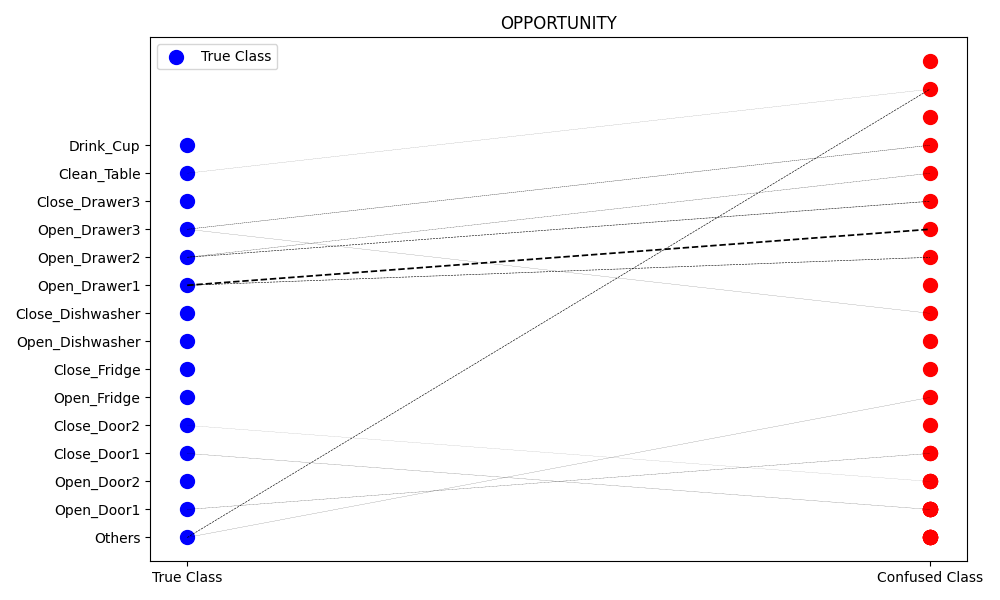

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict

# Assuming DATASET_LIST, labels, and data are defined elsewhere

for dataset_id, dataset in enumerate(data):
    confusion_counts = defaultdict(lambda: defaultdict(int))

    for person in dataset:
        gt = person['gt']
        y = person['y']

        for true_class, pred_class in zip(gt, y):
            confusion_counts[true_class][pred_class] += 1

    df = pd.DataFrame(confusion_counts).fillna(0).astype(int)
    df = df.sort_index()
    df = df.reindex(sorted(df.columns), axis=1)

    print(f"Dataset: {DATASET_LIST[dataset_id]}")
    
    # Prepare data for plotting
    true_classes = []
    confused_classes = defaultdict(list)
    strength = defaultdict(list)

    for true_class in df.index:
        confused_classes_for_true = df.loc[true_class][df.loc[true_class] > 0]
        total_true_class = sum(confused_classes_for_true)  # Total count of confusions for this true class
        print(f"True class: {labels[dataset_id][true_class]}: ", end="")
        true_classes.append(true_class)
        if len(confused_classes_for_true) > 1:
            confused_classes_sorted = confused_classes_for_true.sort_values(ascending=False)
            for confused_class, count in confused_classes_sorted.items():
                if confused_class != true_class:
                    percentage = (count / total_true_class) * 100
                    print(f"{labels[dataset_id][confused_class]} ({percentage:.2f}% - {count}), ", end="")
                    confused_classes[true_class].append(confused_class)
                    strength[true_class].append(percentage)
                else:
                    confused_classes[true_class].append(-1)
                    strength[true_class].append(1)
            print()
        else:
            print("No confusion")
    print()
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    #ax.plot([1, 2], [0, len(true_classes)], 'k-', lw=1)  # Baseline
    
    # Plot true classes
    ax.scatter(np.ones(len(true_classes)), range(len(true_classes)), s=100, c='blue', label='True Class')
    
    # Plot confused classes
    for i, true_class in enumerate(true_classes):
        for j, confused_class in enumerate(confused_classes[true_class]):
            if confused_class==-1 and j!=0:
                print("error")
            # print(confused_class)
            ax.scatter([2], [j], s=100, c='red')
            if confused_class!=-1 and j<3:
                ax.plot([1, 2], [i, confused_class], 'k--', lw=strength[true_class][j]/10)
    
    ax.set_yticks(range(len(true_classes)))
    ax.set_yticklabels([labels[dataset_id][true_class] for true_class in true_classes])
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['True Class', 'Confused Class'])
    ax.legend()
    ax.set_title(DATASET_LIST[dataset_id])
    
    plt.tight_layout()
    plt.show()



In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
import mne
from mne_connectivity.viz import plot_connectivity_circle


# Sample data


# Sample dataset labels
for dataset_id, dataset in enumerate(data):
    confusion_counts = defaultdict(lambda: defaultdict(int))

    for person in dataset:
        gt = person['gt']
        y = person['y']

        for true_class, pred_class in zip(gt, y):
            confusion_counts[true_class][pred_class] += 1

    df = pd.DataFrame(confusion_counts).fillna(0).astype(int)
    df = df.sort_index()
    df = df.reindex(sorted(df.columns), axis=1)

    print(f"Dataset: {DATASET_LIST[dataset_id]}")
    
    # Prepare data for plotting
    true_classes = []
    strength = defaultdict(list)
    chord_matrix = np.zeros((len(df)*2, len(df)*2))
    print(chord_matrix.shape)
    for true_class_idx, true_class in enumerate(df.index):
        true_classes.append(true_class)
        confused_classes_for_true = df.loc[true_class][df.loc[true_class] > 0]
        total_true_class = sum(confused_classes_for_true)
        for confused_class_idx, (confused_class, count) in enumerate(confused_classes_for_true.items()):
            strength[true_class].append(count / total_true_class)
            chord_matrix[true_class_idx, confused_class_idx+len(df)] = 1

   
    node_names = np.array([labels[dataset_id][true_class] for true_class in true_classes])
    node_names = np.concatenate((node_names, node_names))
    print(node_names)
    
    start, end = 45, 135
    first_half = (np.linspace(start, end, len(node_names)//2) +
                90).astype(int)[::+1] % 360
    second_half = (np.linspace(start, end, len(node_names)//2) -
                90).astype(int)[::-1] % 360
    node_angles = np.array(list(first_half) + list(second_half))
    # plot_connectivity_circle(chord_matrix, node_names, n_lines=300, node_angles=None,
    #                          node_colors=None, facecolor='white',
    #                          textcolor='black', colormap='hot', vmin=None, vmax=None,
    #                          colorbar=True, title=DATASET_LIST[dataset_id], fontsize_title=12,
    #                          fontsize_names=10, fontsize_colorbar=10, padding=6.0,
    #                          fig=None, subplot=111, interactive=False)
   # chord_matrix = np.zeros((len(df)*2, len(df)*2))
    chord_matrix = chord_matrix.astype(int)
    
    print(chord_matrix)
    print(np.count_nonzero(chord_matrix))
    print(chord_matrix.dtype)
    plot_connectivity_circle(chord_matrix, node_names,textcolor='black', facecolor='white', node_angles=node_angles, linewidth=0.1 )

Dataset: OPPORTUNITY
(30, 30)


IndexError: index 30 is out of bounds for axis 1 with size 30

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from d3blocks import D3Blocks

id = 0
oppo_special = True
for dataset_id, dataset in enumerate(data):
    if dataset_id==id:
        confusion_counts = defaultdict(lambda: defaultdict(int))
    
        for person in dataset:
            gt = person['gt']
            y = person['y']

            for true_class, pred_class in zip(gt, y):
                confusion_counts[true_class][pred_class] += 1

        df = pd.DataFrame(confusion_counts).fillna(0).astype(int)
        df = df.sort_index()
        df = df.reindex(sorted(df.columns), axis=1)

        print(f"Dataset: {DATASET_LIST[dataset_id]}")
        


        chord_data = []
        for source in df.index:
            strongest_entries = df.loc[source]
            total_true_class = sum(strongest_entries)
            print(total_true_class)
            for target, weight in strongest_entries.items():
                if target != source: 
                # if target != source and source != 0 and target!=0: # Pamap
                # if target != source and source != 10 and target!=10: # FIX
                    
                    chord_data.append({'source': labels[dataset_id][source], 'target': labels[dataset_id][target], 'weight': weight})


        chord_df = pd.DataFrame(chord_data)
        pd.set_option('display.max_rows', None)  # Show all rows
        pd.set_option('display.max_columns', None)  # Show all columns  
        print(chord_df)
        
        # Initialize D3Blocks
        d3 = D3Blocks()
        # if id ==0:
        #     order = ["Cycling", "Running","Ropejump", "Downstairs", "Upstairs", "Nordicwalk", "Walking", "Vaccuum", "Ironing", "Standing", "Sitting", "Lying"]
        #     # order = ["Cycling", "Running","Ropejump", "Downstairs", "Upstairs", "Nordic_walk", "Walking", "Vaccuum", "Ironing", "Standing", "Sitting", "Lying", "Null"]
        # elif id == 4:
        #     order =['Sit', 'Stand', 'Jogging','Walk', 'Upstairs', 'Downstairs' ]
        # else:
        #     order = 'ascending'
        d3.chord(chord_df, showfig=True, filepath='./images/',fontsize=30,arrowhead=30, title=DATASET_LIST[dataset_id], ordering='ascending', figsize=[900, 900])
    


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/Users/geissler/Documents/GitHub/BeyondConfusion/images/d3blocks.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> File already exists and will be overwritten: [/Users/geissler/Documents/GitHub/BeyondConfusion/images/d3blocks.html]


Dataset: OPPORTUNITY
7304
107
114
126
129
21
8
50
16
24
49
75
21
106
488
               source            target  weight
0              Others        Open_Door1      35
1              Others        Open_Door2      23
2              Others       Close_Door1      20
3              Others       Close_Door2      21
4              Others       Open_Fridge     103
5              Others      Close_Fridge      73
6              Others   Open_Dishwasher      61
7              Others  Close_Dishwasher      67
8              Others      Open_Drawer1      53
9              Others     Close_Drawer1      28
10             Others      Open_Drawer2      41
11             Others     Close_Drawer2      26
12             Others      Open_Drawer3      33
13             Others     Close_Drawer3      41
14             Others       Clean_Table      51
15             Others         Drink_Cup     320
16             Others     Toggle_Switch      26
17         Open_Door1            Others       0
18         Open

[d3blocks] >INFO> File not found: [file:////Users/geissler/Documents/GitHub/BeyondConfusion/images/d3blocks.html]
[d3blocks] >INFO> Open browser: file:////Users/geissler/Documents/GitHub/BeyondConfusion/images/d3blocks.html
